# Mid-Lap Predictor

## 00 - Introduction & Project Overview

In [1]:
# Core
import fastf1
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import fastf1.plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

# Feature Engineering
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

from sklearn.ensemble import GradientBoostingRegressor

## 01 - Data Collection

Enabling cache is highly encouraged to speed up the runtime when re-running scripts.

In [2]:
fastf1.Cache.enable_cache("../cache")  # Enable caching to speed up data retrieval

The `get_session()` function is essential for data collection. This function allows us to grab sessions by inputting a particular season, grand prix, and session type (practice, qualifying, race).

In [3]:
# Extract all laps from each session
# for session in ['FP1', 'FP2', 'FP3', 'Q']:
#     session_data = fastf1.get_session(2025, 'Hungary', session)
#     session_data.load()

#     laps = session_data.laps.to_csv(f'../data/raw/2025_Hungary_{session}_laps.csv', index=False)
#     print(f'Saved {session} laps data to CSV.')

 Above we extract laps from practice and qualifying session however, many of the laps collected will be laps that are considered 'not accurate'. This means that many of the laps could be inlaps, outlaps, etc. So we will use the function `pick_quicklaps()` to help extract non-flying laps and laps that are faster than a specific threshold (default is 107% of the best lap).

In [4]:
# Extract quick laps from all sessions
# for session in ['FP1', 'FP2', 'FP3', 'Q']:
#     session_data = fastf1.get_session(2025, 'Hungary', session)
#     session_data.load()

#     laps = session_data.laps.pick_quicklaps() # Pick only quick laps
#     laps.to_csv(f'../data/raw/2025_Hungary_{session}_quicklaps.csv', index=False)
#     print(f'Saved {session} laps data to CSV.')

To make reading the files more efficient, we will combine the laps from each session and create a new column for tagging each session (e.g. FP1, FP2, FP3, Q)

In [5]:
# sessions = ['FP1','FP2','FP3','Q']

# lap_filepaths = [f'../data/raw/2025_Hungary_{s}_laps.csv' for s in sessions]
# ql_filepaths = [f'../data/raw/2025_Hungary_{s}_quicklaps.csv' for s in sessions]

# lap_output = '../data/raw/2025_Hungary_all_laps.csv'
# ql_output = '../data/raw/2025_Hungary_all_quicklaps.csv'

# dfs = [] # List to hold dataframe for the laps
# for sess, fp in zip(sessions, ql_filepaths): # Iterate over sessions and filepaths using zip()
#     df = pd.read_csv(fp) # Read the CSV file into a DataFrame
#     df['SessionType'] = sess # Add a new column for session type
#     dfs.append(df)

# all_laps = pd.concat(dfs, ignore_index=True) # Concatenate all DataFrames into one
# all_laps.to_csv(ql_output, index=False)

The reason we will need these two seperate files is because using the `pick_quicklaps()` filters out laps that are inlaps and outlaps which we may need later on if we wanted to possibly research features such as tire degradation and the lap time loss due to tire deg.

In [6]:
# Read laps and quicklaps data
laps = pd.read_csv("../data/raw/2025_Hungary_all_laps.csv")
quicklaps = pd.read_csv("../data/raw/2025_Hungary_all_quicklaps.csv")

print(laps.shape)
print(quicklaps.shape)

(1729, 32)
(396, 32)


## 02 - Data Cleaning

In [7]:
# Need to convert to time delta first, then to seconds
laps["LapTime (s)"] = pd.to_timedelta(laps["LapTime"]).dt.total_seconds()
laps["Sector1Time (s)"] = pd.to_timedelta(laps["Sector1Time"]).dt.total_seconds()
laps["Sector2Time (s)"] = pd.to_timedelta(laps["Sector2Time"]).dt.total_seconds()
laps["Sector3Time (s)"] = pd.to_timedelta(laps["Sector3Time"]).dt.total_seconds()
laps["TyreLife"] = laps["TyreLife"].astype(int)

In [8]:
quicklaps["LapTime (s)"] = pd.to_timedelta(quicklaps["LapTime"]).dt.total_seconds()
quicklaps["Sector1Time (s)"] = pd.to_timedelta(
    quicklaps["Sector1Time"]
).dt.total_seconds()
quicklaps["Sector2Time (s)"] = pd.to_timedelta(
    quicklaps["Sector2Time"]
).dt.total_seconds()
quicklaps["Sector3Time (s)"] = pd.to_timedelta(
    quicklaps["Sector3Time"]
).dt.total_seconds()
quicklaps["TyreLife"] = quicklaps["TyreLife"].astype(int)

In [9]:
# Quick check to filter out any lap times that are deleted and not accurate
quicklaps = quicklaps[
    (quicklaps["Deleted"] == False) & (quicklaps["IsAccurate"] == True)
]
print(quicklaps.shape)

(393, 36)


The `describe()` is a great function to help analyze the dataset and make sure that there are no significant outliers skewing the data. As you can see when we print the statistics with `describe()`, the difference between **unfiltered** and the **quicklaps** is significant. The unfiltered laps have a mean laptime of 97.84 seconds whereas the quicklaps have a mean laptime of 77.35 seconds.

In [10]:
print(
    "Unfiltered Laps\n",
    laps[
        [
            "LapTime (s)",
            "Sector1Time (s)",
            "Sector2Time (s)",
            "Sector3Time (s)",
            "TyreLife",
        ]
    ].describe(),
)
print(
    "Quick Laps\n",
    quicklaps[
        [
            "LapTime (s)",
            "Sector1Time (s)",
            "Sector2Time (s)",
            "Sector3Time (s)",
            "TyreLife",
        ]
    ].describe(),
)

Unfiltered Laps
        LapTime (s)  Sector1Time (s)  Sector2Time (s)  Sector3Time (s)  \
count  1366.000000      1429.000000      1729.000000      1718.000000   
mean     97.848586        37.123642        35.484655        27.882754   
std      22.271618        12.259754         8.306439         7.257818   
min      74.890000        27.357000        26.263000        21.012000   
25%      79.163500        28.723000        28.961000        22.993000   
50%      84.129000        30.020000        33.304000        25.565500   
75%     116.767500        42.653000        40.756000        30.883750   
max     149.373000        98.796000        72.299000        73.483000   

          TyreLife  
count  1729.000000  
mean      7.426258  
std       5.826228  
min       1.000000  
25%       3.000000  
50%       6.000000  
75%      11.000000  
max      26.000000  
Quick Laps
        LapTime (s)  Sector1Time (s)  Sector2Time (s)  Sector3Time (s)  \
count   393.000000       393.000000       393.00000

## 03 - Exploratory Data Analysis

In [11]:
plt.style.use("dark_background")  # Enable dark background for plt

### 3.1 Lap Time Distribution by Tire Compound

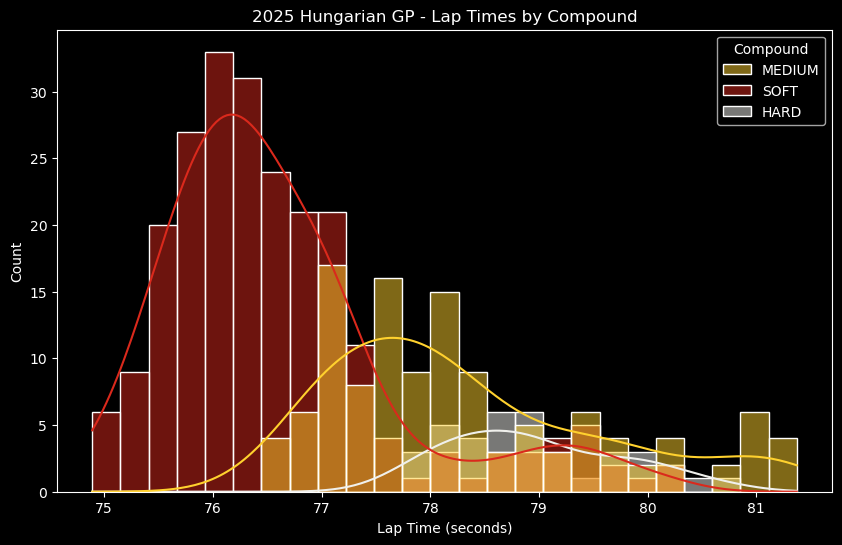

In [12]:
session = fastf1.get_session(2025, "Hungary", "FP1")
compound_colors = fastf1.plotting.get_compound_mapping(
    session
)  # Returns a dictionary of compounds and its hexadecimal rgb color

plt.figure(figsize=(10, 6))

sns.histplot(
    data=quicklaps,
    x="LapTime (s)",
    hue="Compound",
    kde=True,
    bins=25,
    palette=compound_colors,
)
plt.title("2025 Hungarian GP - Lap Times by Compound")
plt.xlabel("Lap Time (seconds)")
plt.show()

**Observation:**

**Soft compounds laps cluster around 76 seconds and has a tighter spread compared to the other compounds**. Mediums are slower than softs on average but have more variation and a wider spread compared to the Softs. The Hards are the slowest compounds but have a lower variance than the Mediums and is more consistent.

**Why it Matters:**

This confirms the performance hierarchy of tire compounds in lap time but also shows us the inconsistency in Mediums. For lap time prediction, tire compound could be a key feature for modeling pace differences.

**Action Items:**
- Encode tire compound (e.g. One Hot Encoding) for capturing pace differences between tire compounds.
- Consider interaction features between compound and tire life, since tire degradation can impact lap times.
- Find and filter out outliers within each compound category to improve model training stability.

### 3.2 Relationship Between Lap Time and Tire Compounds

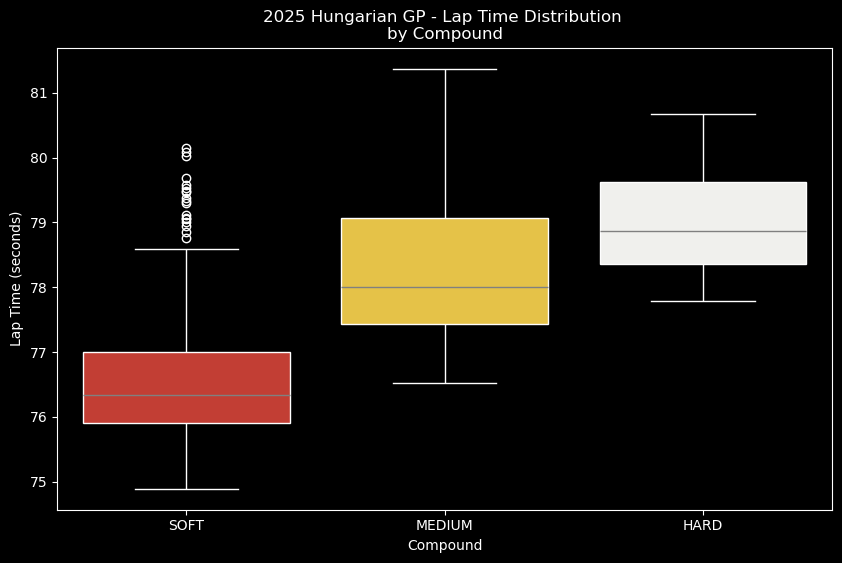

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=quicklaps,
    x="Compound",
    y="LapTime (s)",
    hue="Compound",
    palette=compound_colors,
    order=["SOFT", "MEDIUM", "HARD"],
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
    flierprops=dict(markeredgecolor="white"),
)
plt.title("2025 Hungarian GP - Lap Time Distribution \nby Compound")
plt.ylabel("Lap Time (seconds)")
plt.show()

**Observation:**

The **Soft compound has the lowest mean lap time (~76.3 seconds)** and has the **narrowest IQR (~1.1 seconds)**, showing that many of the lap times placed with the Softs are close to the median and is consistent. **Mediums are slower on average (~78.3 seconds)** with a **slight higher variance (~1.6 seconds)**. **Hard compound are the slowest on average (~78.9)** with a **slightly more consistent IQR than mediums (~1.3 seconds)**. There are many outliers with the Soft compounds that may need to be filtered out.

**Why it Matters:**

This supports the hierarchy between the compounds and gives us an idea of how much time is gained/loss depending on the choice of compound. This plot also helped us see outliers that we could not have seen precisely with the histogram, these outliers could possibly effect our model's performance and accuracy.

**Action Items:**

- Encode tire compound (e.g. One Hot Encoding) for capturing pace differences between tire compounds.
- Consider interaction features between compound and tire life, since tire degradation can impact lap times.
- Explore the outliers with the Soft compounds and potentially remove them.


### 3.3 Dealing with Soft Compound Outliers

Here we will explore the Soft compound outliers and observe if the outliers are worth removing from the dataset. We want to make sure that the outliers do not significantly effect our model later on. We will start by calculating the percentiles, interquartile range, upper, and lower bounds for each compound. Then we will create a function that checks if a row is outside of the bounds and mark those rows as outliers to easily flag outliers.

#### 3.3.1 Flagging Rows as Outliers

In [14]:
q1 = quicklaps.groupby("Compound")["LapTime (s)"].quantile(
    0.25
)  # Return 25th percentile grouped by compound
q3 = quicklaps.groupby("Compound")["LapTime (s)"].quantile(
    0.75
)  # Return 75th percentile grouped by compound
iqr = q3 - q1  # Calculate interquartile range
upper_bound = q3 + 1.5 * iqr  # Calculate upper bound for outliers
lower_bound = q1 - 1.5 * iqr  # Calculate lower bound for outliers

In [15]:
def is_outlier(row, lower_bound, upper_bound):
    """
    Determines whether a lap time is an outlier based on its IQR bounds.

    Parameters:
        row (pd.Series): A single row from the DataFrame containing LapTime and Compound.
        lower_bound (pd.Series): Lower bound values indexed by compound.
        upper_bound (pd.Series): Upper bound values indexed by compound.

    Returns:
        bool: True if the lap time is an outlier, False otherwise.
    """
    compound = row["Compound"]
    lap_time = row["LapTime (s)"]

    return (lap_time > upper_bound.loc[compound]) or (
        lap_time < lower_bound.loc[compound]
    )

In [16]:
# Apply the is_outlier function to each row in the DataFrame
quicklaps["IsOutlier"] = quicklaps.apply(
    is_outlier, axis=1, args=(lower_bound, upper_bound)
)

In [17]:
soft_outliers = quicklaps[
    (quicklaps["Compound"] == "SOFT") & (quicklaps["IsOutlier"])
]  # Filter for soft tire outliers
print("Outliers for Soft Compound\n", soft_outliers[["Driver", "LapTime (s)"]])

Outliers for Soft Compound
     Driver  LapTime (s)
156    ALB       78.765
200    VER       80.089
201    VER       80.018
202    VER       79.580
212    BOR       79.524
213    BOR       78.943
214    BOR       79.382
223    GAS       79.485
224    GAS       79.297
225    GAS       79.474
226    GAS       79.679
233    ANT       79.046
234    ANT       79.337
256    TSU       79.069
264    HUL       79.108
266    HUL       78.999
267    HUL       78.845
268    HUL       80.144


#### 3.3.2 Comparing Statistics (Outliers vs. Without Outliers)
Now that we have flagged the Soft compound outliers, we will calculate and compare the statistics with and without outliers.

In [18]:
# Statistics with outliers
print("With Outliers:\n", quicklaps.groupby("Compound")["LapTime (s)"].describe())
print("\nVariance with outliers:\n", quicklaps.groupby("Compound")["LapTime (s)"].var())
print(
    "\nStandard Deviation with outliers:\n",
    quicklaps.groupby("Compound")["LapTime (s)"].std(),
)
print("---------------------------------------------")

# Statistics without soft outliers
quicklaps_no_soft_outliers = quicklaps[
    ~((quicklaps["Compound"] == "SOFT") & (quicklaps["IsOutlier"]))
]
print(
    "Without Soft Outliers:\n",
    quicklaps_no_soft_outliers.groupby("Compound")["LapTime (s)"].describe(),
)
print(
    "\nVariance without soft outliers:\n",
    quicklaps_no_soft_outliers.groupby("Compound")["LapTime (s)"].var(),
)
print(
    "\nStandard Deviation without soft outliers:\n",
    quicklaps_no_soft_outliers.groupby("Compound")["LapTime (s)"].std(),
)

With Outliers:
           count       mean       std     min       25%      50%       75%  \
Compound                                                                    
HARD       38.0  78.957395  0.780880  77.794  78.36275  78.8700  79.62050   
MEDIUM    123.0  78.329309  1.257508  76.525  77.43150  78.0100  79.07000   
SOFT      232.0  76.584733  1.063557  74.890  75.91100  76.3385  77.00475   

             max  
Compound          
HARD      80.667  
MEDIUM    81.372  
SOFT      80.144  

Variance with outliers:
 Compound
HARD      0.609774
MEDIUM    1.581327
SOFT      1.131153
Name: LapTime (s), dtype: float64

Standard Deviation with outliers:
 Compound
HARD      0.780880
MEDIUM    1.257508
SOFT      1.063557
Name: LapTime (s), dtype: float64
---------------------------------------------
Without Soft Outliers:
           count       mean       std     min       25%      50%      75%  \
Compound                                                                   
HARD       38.0  78

From the results we can see a decrease in variance and the standard deviation for Soft compound without the outliers. In fact, there was a significant reduction in variance for the soft compound from **~1.13** to **~0.49** and a great reduction in standard deviation from **~1.06** to **~0.70**. This means that if we remove the Soft compound outliers, we would achieve a more consistent dataset and a higher quality model later on.

#### 3.3.2 Removing Soft Compound Outliers

In [19]:
cleaned_quicklaps = quicklaps_no_soft_outliers

### 3.4 Relationship Between Lap Time and Tire Compounds (Soft Outliers Removed)

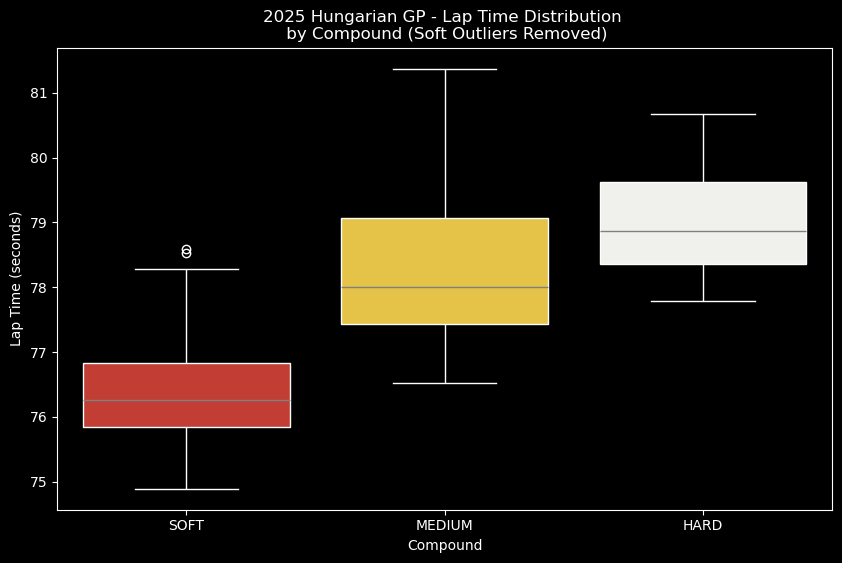

In [20]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=cleaned_quicklaps,
    x="Compound",
    y="LapTime (s)",
    hue="Compound",
    palette=compound_colors,
    order=["SOFT", "MEDIUM", "HARD"],
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
    flierprops=dict(markeredgecolor="white"),
)

plt.title(
    "2025 Hungarian GP - Lap Time Distribution \n by Compound (Soft Outliers Removed)"
)
plt.ylabel("Lap Time (seconds)")
plt.show()

In [21]:
print(
    "Soft Compound Statistics:\n",
    cleaned_quicklaps[cleaned_quicklaps["Compound"] == "SOFT"][
        "LapTime (s)"
    ].describe(),
)

Soft Compound Statistics:
 count    214.000000
mean      76.349879
std        0.706135
min       74.890000
25%       75.842250
50%       76.256500
75%       76.825500
max       78.585000
Name: LapTime (s), dtype: float64


**Observation:**

After removing the outliers from the Soft compound, the number of extreme lap times decreased substantially. A few points still remain outside the boxplot whiskers, but these are not significant based on the `.describe()` results. **The maximum lap time for Softs is now ~78.58 seconds versus ~80.14 with outliers**, while the **mean is ~76.34 seconds versus ~76.58**.

**Why it Matters:**

Removing the significant outliers reduces noise in the dataset, lowering the variance and standard deviation for Softs. This increases the consistency of lap time data and should improve model quality later on when we work on our model. The remaining Soft laps are within a normal range and may represent legitimate slower laps, so they will be left in the dataset for now.


**Action Items:**

- Encode tire compound (e.g. One Hot Encoding) for capturing pace differences between tire compounds.
- Consider interaction features between compound and tire life, since tire degradation can impact lap times.
- After feature engineering, assess if the outliers were valid outliers due to race conditions or not.


### 3.5 LapTime vs Tire Life: Detecting Effects of Tire Degradation

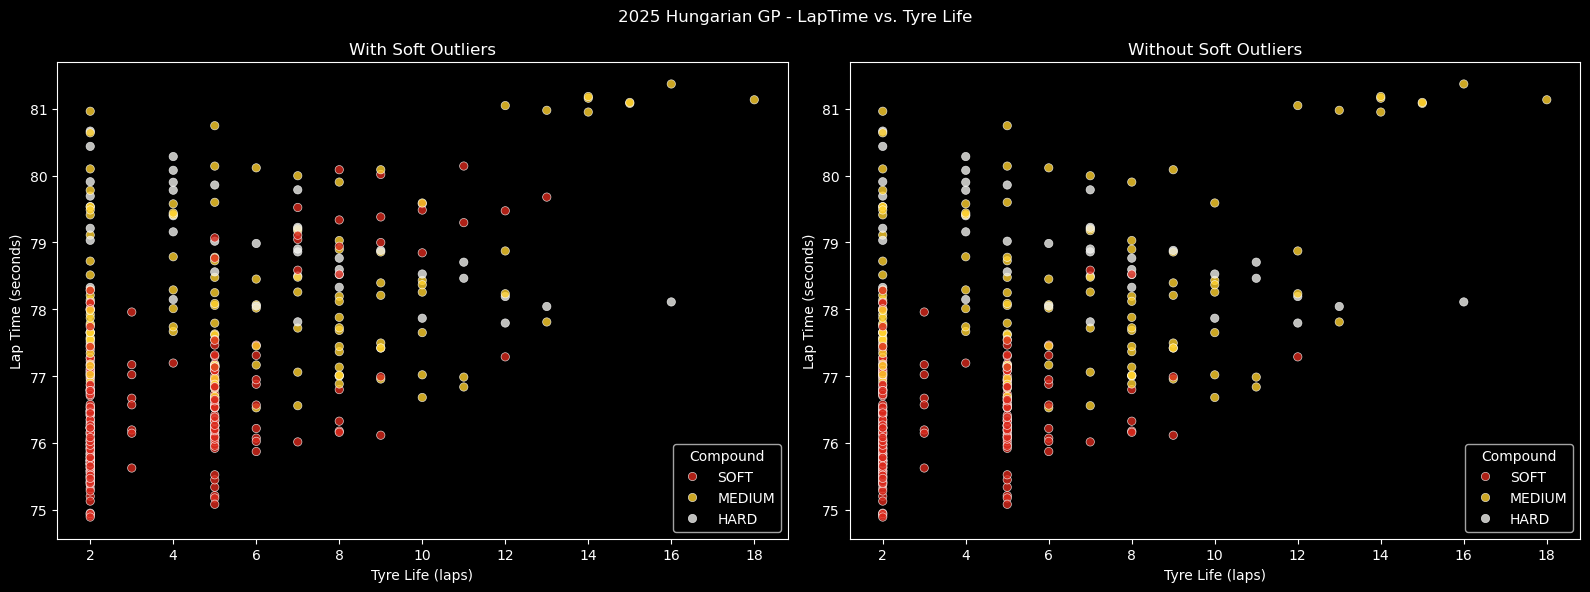

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

order = ["SOFT", "MEDIUM", "HARD"]

sns.scatterplot(
    data=quicklaps,
    x="TyreLife",
    y="LapTime (s)",
    hue="Compound",
    hue_order=order,
    palette=compound_colors,
    alpha=0.8,
    ax=ax[0],
)
sns.scatterplot(
    data=cleaned_quicklaps,
    x="TyreLife",
    y="LapTime (s)",
    hue="Compound",
    hue_order=order,
    palette=compound_colors,
    alpha=0.8,
    ax=ax[1],
)

fig.suptitle("2025 Hungarian GP - LapTime vs. Tyre Life")
ax[0].set_title("With Soft Outliers")
ax[1].set_title("Without Soft Outliers")

for a in ax:
    a.set_xlabel("Tyre Life (laps)")
    a.set_ylabel("Lap Time (seconds)")

plt.tight_layout()
plt.show()

**Observation:**

The Soft compound has a consistent performance between the tire life of 2-5 laps at ~75-78 seconds, then the lap time starts spread upwards after lap 6 showing outliers that could be due to tire degradation. We can see several outliers for the Medium compound as well that could be explained by tire degradation. The Hard compound has a steady performance with some outliers beyond a tire life of 10 laps.


**Why it Matters:**

Seeing the performance decrease as a stint extends gives us an idea of how much tire degradation impacts performance. This can help our model learn the pace drop-off as tire life increases.

**Action Items:**

- Consider tire degradation as a feature to capture the impact of pace as stint extends.
- Train a "cleaned" model with the Soft compound outliers removed and compare model performances.

### 3.6 Impact of Teams on Pace

In [23]:
team_order = (
    quicklaps[["Team", "LapTime (s)"]]
    .groupby("Team")
    .median()
    .sort_values("LapTime (s)")
    .index
)
print(team_order)

team_palette = {
    team: fastf1.plotting.get_team_color(team, session=session) for team in team_order
}

req            INFO 	Using cached data for driver_info


Index(['McLaren', 'Ferrari', 'Aston Martin', 'Mercedes', 'Racing Bulls',
       'Haas F1 Team', 'Williams', 'Alpine', 'Red Bull Racing', 'Kick Sauber'],
      dtype='object', name='Team')


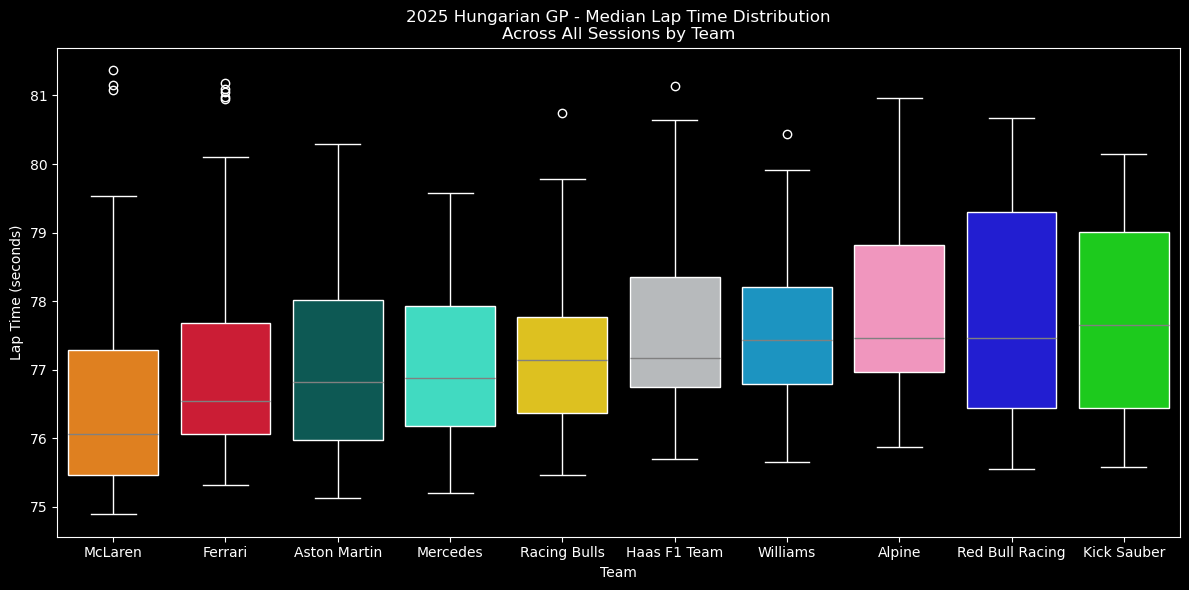

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=quicklaps,
    x="Team",
    y="LapTime (s)",
    hue="Team",
    palette=team_palette,
    order=team_order,
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
    flierprops=dict(markeredgecolor="white"),
)

plt.title(
    "2025 Hungarian GP - Median Lap Time Distribution\nAcross All Sessions by Team"
)
plt.ylabel("Lap Time (seconds)")
plt.tight_layout()
plt.show()

In [25]:
fp1 = quicklaps[quicklaps["SessionType"] == "FP1"]
fp2 = quicklaps[quicklaps["SessionType"] == "FP2"]
fp3 = quicklaps[quicklaps["SessionType"] == "FP3"]
qualy = quicklaps[quicklaps["SessionType"] == "Q"]

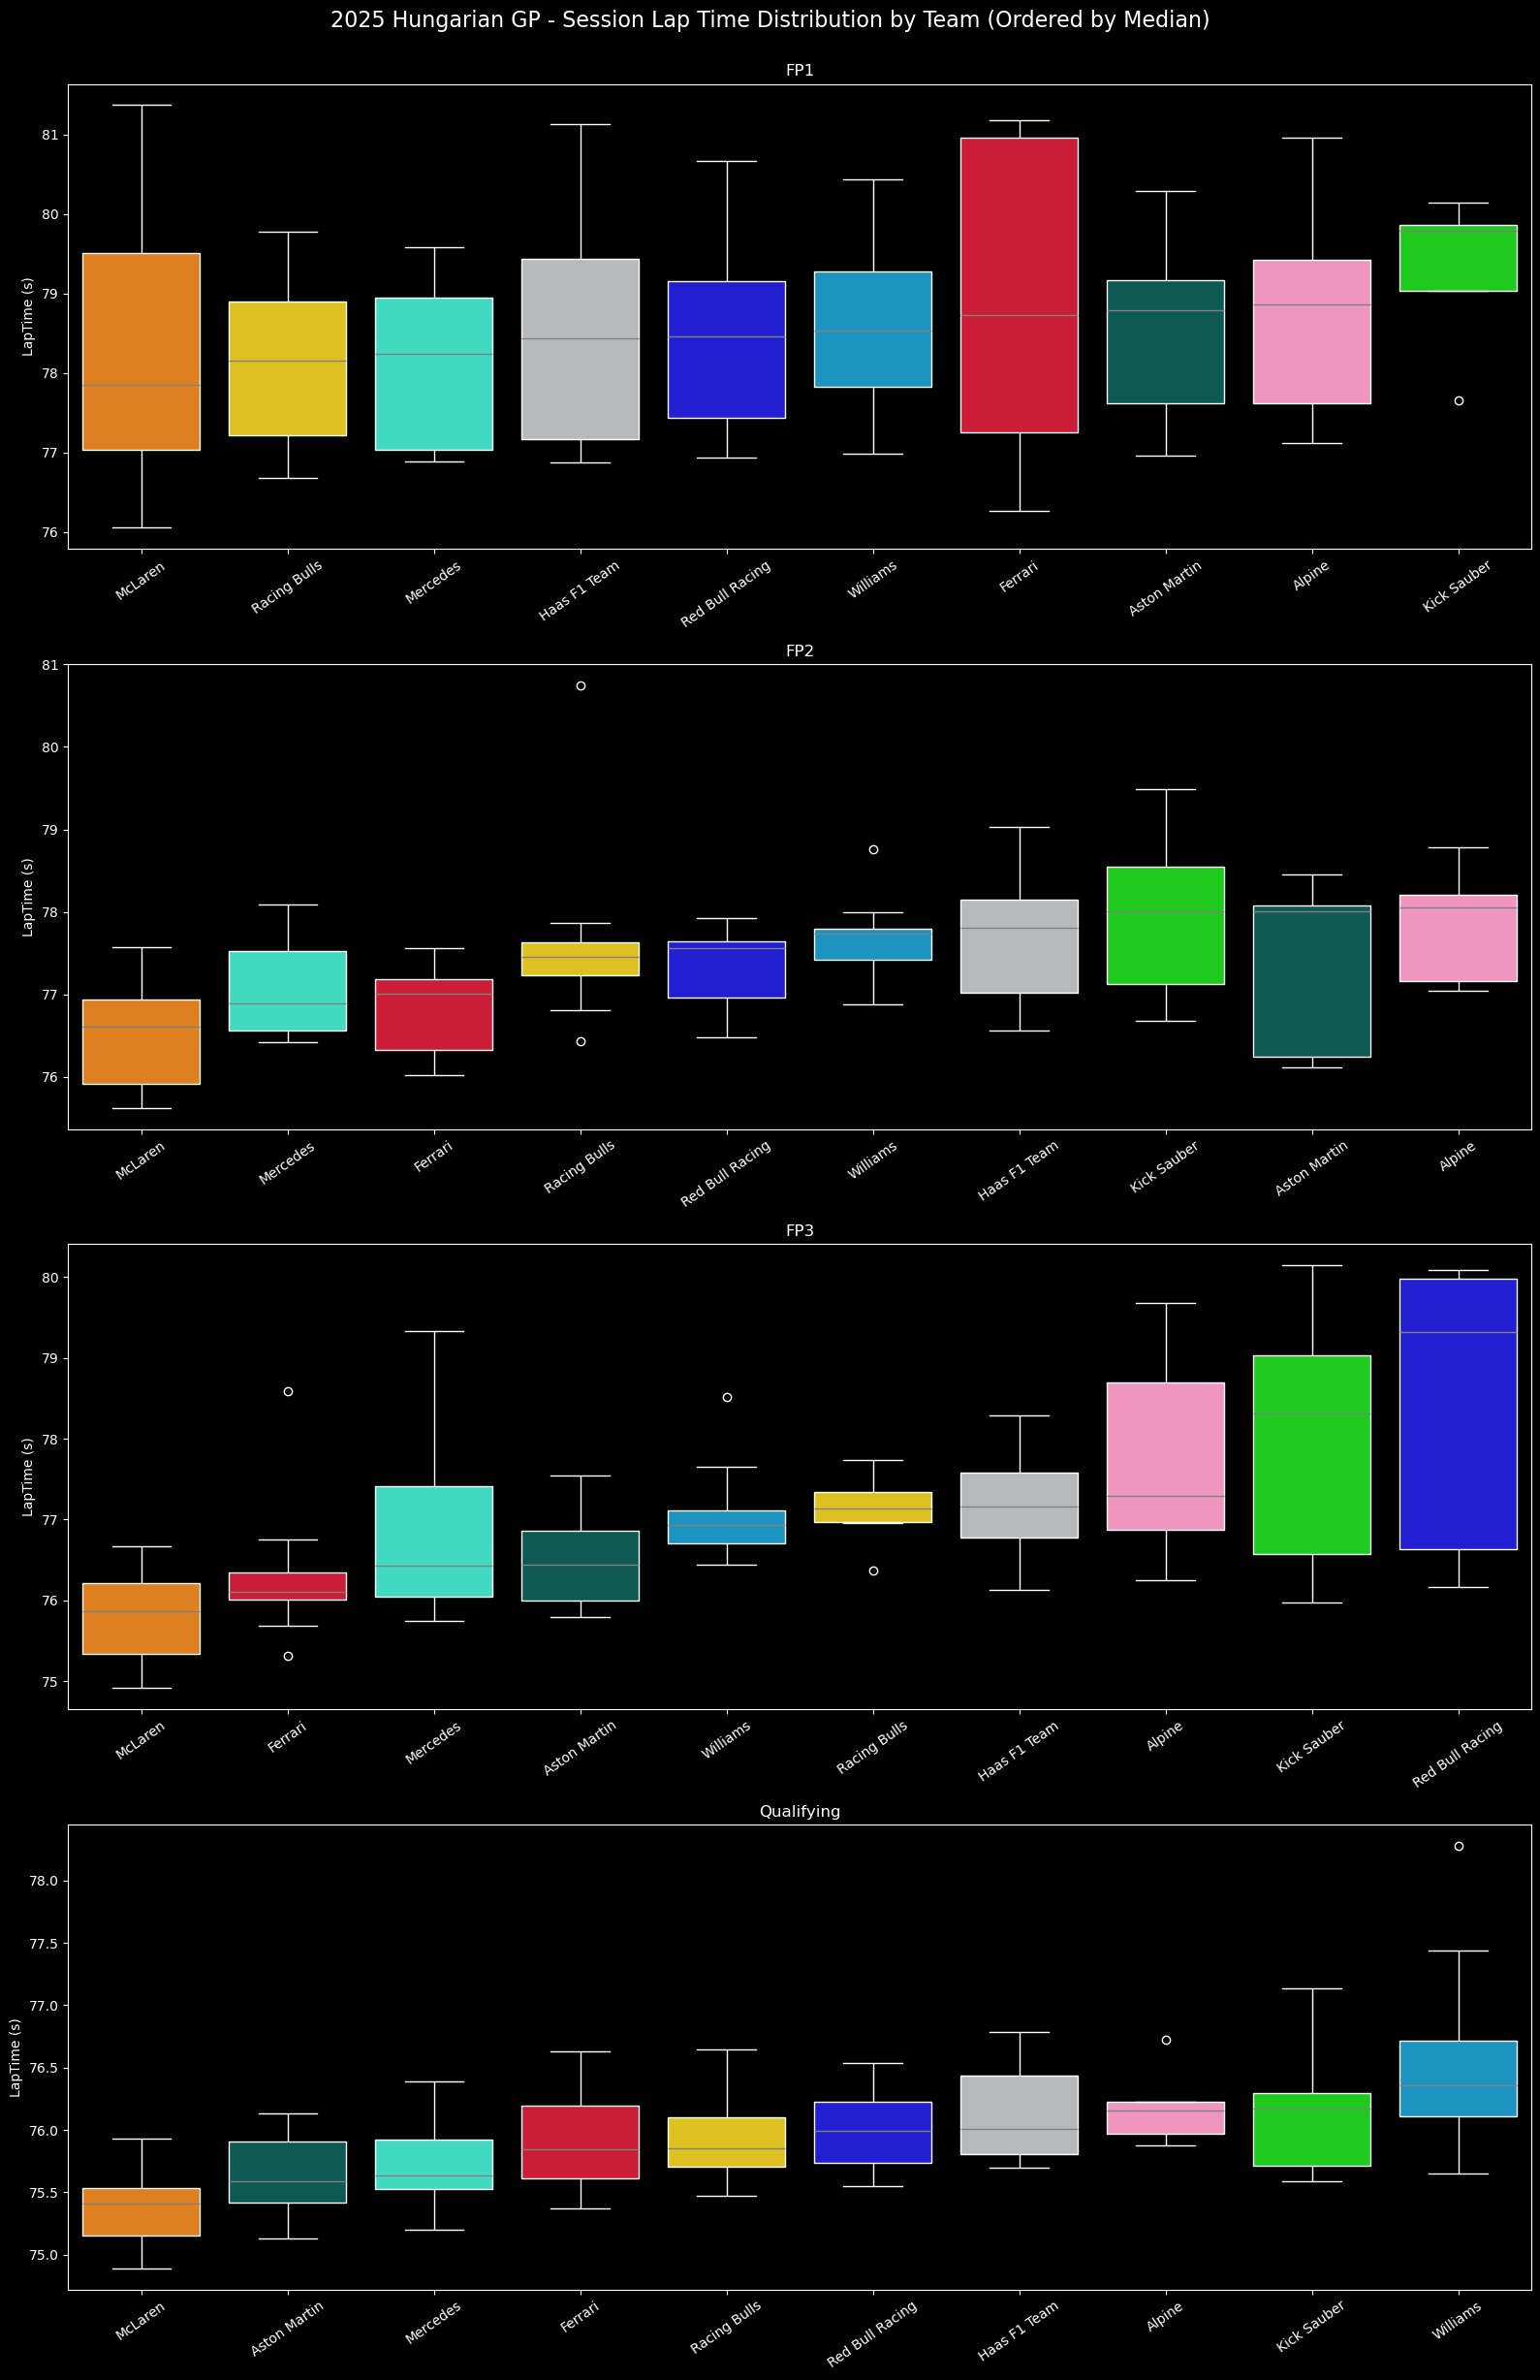

In [26]:
sessions = {"FP1": fp1, "FP2": fp2, "FP3": fp3, "Qualifying": qualy}

fig, axs = plt.subplots(4, 1, figsize=(16, 25))

for ax, (title, df) in zip(axs, sessions.items()):
    order = (
        df[["Team", "LapTime (s)"]]
        .groupby("Team")
        .median()
        .sort_values("LapTime (s)")
        .index
    )

    sns.boxplot(
        data=df,
        x="Team",
        y="LapTime (s)",
        hue="Team",
        palette=team_palette,
        order=order,
        whiskerprops=dict(color="white"),
        boxprops=dict(edgecolor="white"),
        medianprops=dict(color="grey"),
        capprops=dict(color="white"),
        flierprops=dict(markeredgecolor="white"),
        ax=ax,
    )

    ax.set_title(title)
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=35)

fig.suptitle(
    "2025 Hungarian GP - Session Lap Time Distribution by Team (Ordered by Median)\n\n",
    fontsize=16,
)

plt.tight_layout()
plt.show()

**Observation:**

McLaren consistently demonstrated the strongest pace across all sessions (excluding the race), while other teams displayed greater variability. FP1 should be treated carefully, as teams often use it to test different setups, which explains the wider spread (wider boxes) in lap times. For instance, Aston Martin’s pace appeared slower in practice but improved greatly in qualifying session, whereas Ferrari showed steady gains through practice sessions but underperformed in qualifying.


**Why it Matters:**

Team pace differences highlight the performance gap between cars and teams. Front-running teams are expected to outperform the midfield and backmarker teams, and these front-runners are typically reflected at the top of the Constructors’ standings. Modeling team pace as a feature ensures the model accounts for these inherent differences, making lap time predictions more realistic.

**Action Items:**

- Include team identifier as a feature for capturing pace differences in teams.
- Consider Constructor's standing as a means for modeling pace differences in teams as session pace between teams can vary.


### 3.7 Correlation Heatmap

<Axes: >

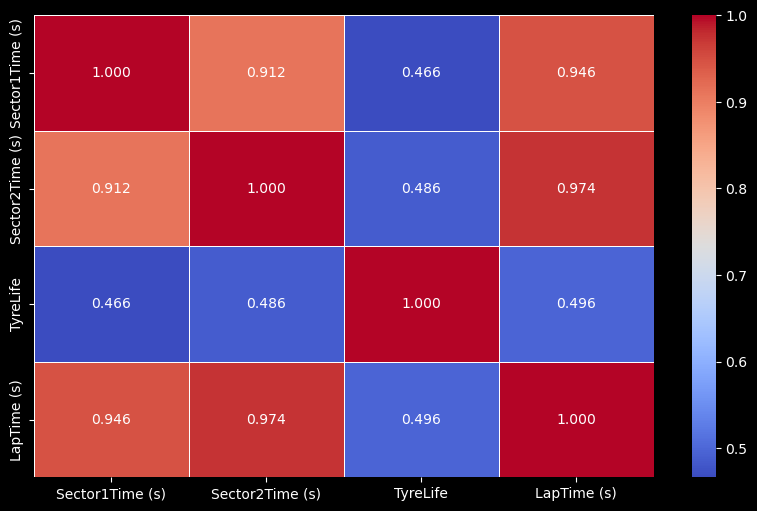

In [27]:
corr = quicklaps[['Sector1Time (s)', 'Sector2Time (s)', 'TyreLife', 'LapTime (s)']].corr()

plt.figure(figsize=(10, 6))

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.3f',linewidths=0.5)

### 3.8 Summary

- **Tire Compound:** Soft tires showed the fastest pace overall, with a tighter spread in lap times compared to Mediums and Hards. However, Softs also showed the steepest performance decline due to degradation, especially after 2–5 laps. Medium and Hard compounds were slower but were more stable across stints.

- **Tire Life:** Stint length has a clear impact on lap time. Extended use of tires especially in Softs had noticeable increase in lap time, reinforcing the need to account for degradation effects on performance. Though from the correlation heatmap, Tire Life have a moderate correlation of ~0.49 with lap time, it is still worth keeping the feature as degradation compounds over time.

- **Outliers:** Initial removal of Soft compound outliers reduced variance and improved data consistency. Another look revealed these “outliers” often resulted from possible tire wear rather than errors, so they should be kept to reflect the realism of race conditions.

- **Team Pace:** Significant performance gaps exist between teams. Front-runners consistently outperform midfield and backmarker teams, aligning with Constructors’ standings. Incorporating team identity is crucial to capture the differences in pace between teams

- **Sector Times:** Sector Times will have a high correlation with LapTime due to lap time being the sum of sector times. We have excluded Sector 3 time as it would give the exact answer for our mid-lap final lap time predictor. It is also important to note that Sector 1 and Sector 2 have a correlation of ~0.91 which suggests multicollinearity which we should be careful with as we proceed.

#### Key Features

- Tire Compound
- Tire Life (Stint Length)
- Team  
- Sector Time (1 & 2)

## 04 - Feature Engineering

### 4.1 Tire Compound & Team (One-hot encoding)

Before building the model, we need to process the features so they are in a format the model can interpret. In this dataset, we have two categorical features: **Compound and Team**, along with three numerical features: **TyreLife, Sector1Time (s), and Sector2Time (s)**.

Machine learning models cannot directly work with categorical values such as Soft, Medium, Hard, or team names. So, we need make these features usable by applying **One-Hot Encoding**, which converts each category into binary (0/1) variables.

In [28]:
X = quicklaps[
    ["Compound", "Team", "TyreLife", "Sector1Time (s)", "Sector2Time (s)"]
].copy()  # Features

# Feature groups (Categorical and numeric)
CATEGORICAL_COLS = ["Compound", "Team"]
NUMERIC_COLS = ["TyreLife", "Sector1Time (s)", "Sector2Time (s)"]

# One Hot Encoder for converting categorical features into numeric
ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)

# Apply OHE to categorical features and passthrough numeric features
feature_transformer = ColumnTransformer(
    transformers=[
        (
            "ohe_compound_team",
            ohe,
            CATEGORICAL_COLS,
        ),  # One Hot Encode categorical features
        ("pass_numeric", "passthrough", NUMERIC_COLS),  # Pass through numeric features
    ],
    remainder="drop",  # Drop any remaining columns not specified in transformers (default)
)

# .fit() + .transform() the data
X_transformed = feature_transformer.fit_transform(X)

# Get the feature names after transformation
ohe_feature_names = feature_transformer.named_transformers_[
    "ohe_compound_team"
].get_feature_names_out(CATEGORICAL_COLS)

### 4.2 Combining OHE Features & Tire Life

In [29]:
# Combine OHE features with already numeric (TyreLife)
final_feature_names = (
    list(ohe_feature_names) + NUMERIC_COLS
)  

# Replace spaces with underscores
final_feature_names = [
    n.replace(" ", "_") for n in final_feature_names
]  
display(final_feature_names)

['Compound_MEDIUM',
 'Compound_SOFT',
 'Team_Aston_Martin',
 'Team_Ferrari',
 'Team_Haas_F1_Team',
 'Team_Kick_Sauber',
 'Team_McLaren',
 'Team_Mercedes',
 'Team_Racing_Bulls',
 'Team_Red_Bull_Racing',
 'Team_Williams',
 'TyreLife',
 'Sector1Time_(s)',
 'Sector2Time_(s)']

### 4.3 Converting Features to Dataframe

In [30]:
# Convert to DataFrame for easier handling
X_encoded = pd.DataFrame(X_transformed, columns=final_feature_names, index=X.index)
print("Transformed feature shape:", X_encoded.shape)
display(X_encoded.head())

Transformed feature shape: (393, 14)


,Compound_MEDIUM,Compound_SOFT,Team_Aston_Martin,Team_Ferrari,Team_Haas_F1_Team,Team_Kick_Sauber,Team_McLaren,Team_Mercedes,Team_Racing_Bulls,Team_Red_Bull_Racing,Team_Williams,TyreLife,Sector1Time_(s),Sector2Time_(s)
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,29.028,28.290
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,28.757,27.863
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,28.522,27.718
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,28.427,27.260
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,28.193,27.045


## 05 - Model 1 - Linear Regression

### 5.1 Initializing Model

In [31]:
X = X_encoded  # Update X with the transformed features (has been fitted and transformed)
y = quicklaps["LapTime (s)"].astype(
    float
)  # Define target variable as LapTime in seconds
print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


model = LinearRegression()
model.fit(X_train, y_train)  # Fit the model to the training data

b = model.intercept_  # Get the intercept
w = model.coef_  # Get the coefficients

y_pred = model.predict(X_test)  # Predict LapTimes for the test set

Feature matrix shape: (393, 14)
Target variable shape: (393,)


### 5.2 Model Evaluation Metrics

In [32]:
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = root_mean_squared_error(y_test, y_pred)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
rsq = r2_score(y_test, y_pred)  # R-squared score
print(f"Mean Squared Error (MSE): {mse:.3f} seconds²")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f} seconds")
print(f"Mean Absolute Error (MAE): {mae:.3f} seconds")
print(f"R-squared R²: {rsq:.3f}")

print("\nModel Parameters:")
print("Intercept (b):", b)  # Baseline LapTime
print("Coefficients (w):")  # Weights for each feature (dropped Hard and Team_Alpine )
coef_df = pd.DataFrame({"Feature": X_train.columns, "Coefficient": model.coef_})

# Sort by magnitude of coefficients (greatest impact on LapTime)
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)
display(coef_df)

Mean Squared Error (MSE): 0.056 seconds²
Root Mean Squared Error (RMSE): 0.237 seconds
Mean Absolute Error (MAE): 0.154 seconds
R-squared R²: 0.973

Model Parameters:
Intercept (b): 7.541956298996212
Coefficients (w):


,Feature,Coefficient
13,Sector2Time_(s),1.593943
12,Sector1Time_(s),0.923860
0,Compound_MEDIUM,0.131817
9,Team_Red_Bull_Racing,0.120923
3,Team_Ferrari,0.094385
1,Compound_SOFT,0.071873
7,Team_Mercedes,0.066688
10,Team_Williams,0.064269
2,Team_Aston_Martin,0.064139
5,Team_Kick_Sauber,-0.063393


The linear regression model achieved an **R-squared of 0.973**, meaning the model explains about **97% of the variance in lap times.** This R² score indicates that the model captures most of the key patterns in the data.

The **Mean Absolute Error (MAE) of 0.154 seconds** shows that on average, lap time predictions are within **0.15 seconds of the actual lap times**. Meanwhile, the **Root Mean Squared Error (RMSE) of 0.237 seconds** suggests that even when errors occur, they typically fall within a quarter of a second.

In summary, these results demonstrate that the model performs quite well already and may be near what is possibly achievable this linear regression model.

### 5.3 Plotting Linear Regression

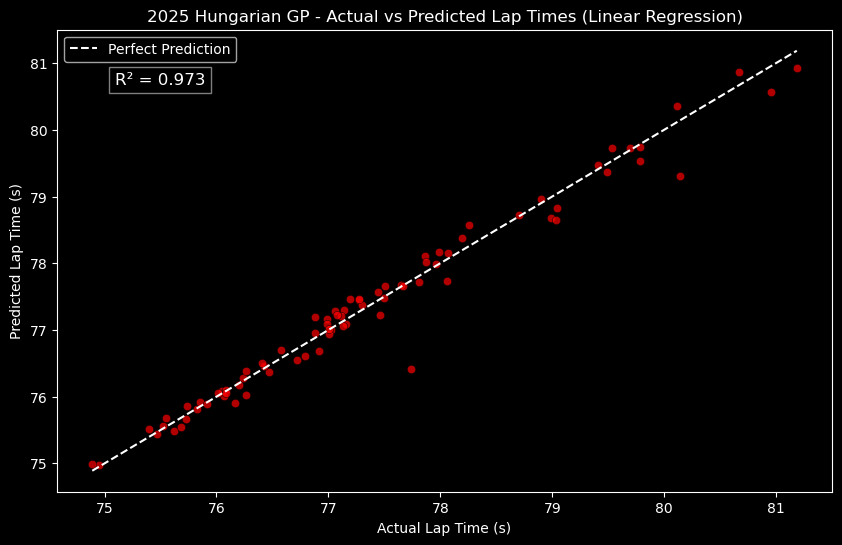

In [33]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=y_test, y=y_pred, color="red", alpha=0.7, edgecolor="black")

# Add 45° perfect prediction line
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--",
    color="white",
    label="Perfect Prediction",
)

plt.xlabel("Actual Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("2025 Hungarian GP - Actual vs Predicted Lap Times (Linear Regression)")

# R-squared value on plot
plt.text(
    x=y_test.min() + 0.2,
    y=y_test.max() - 0.5,
    s=f"R² = {rsq:.3f}",
    fontsize=12,
    bbox=dict(facecolor="black", alpha=0.5, edgecolor="white"),
)

plt.legend()
plt.show()

### 5.4 Residuals Plot

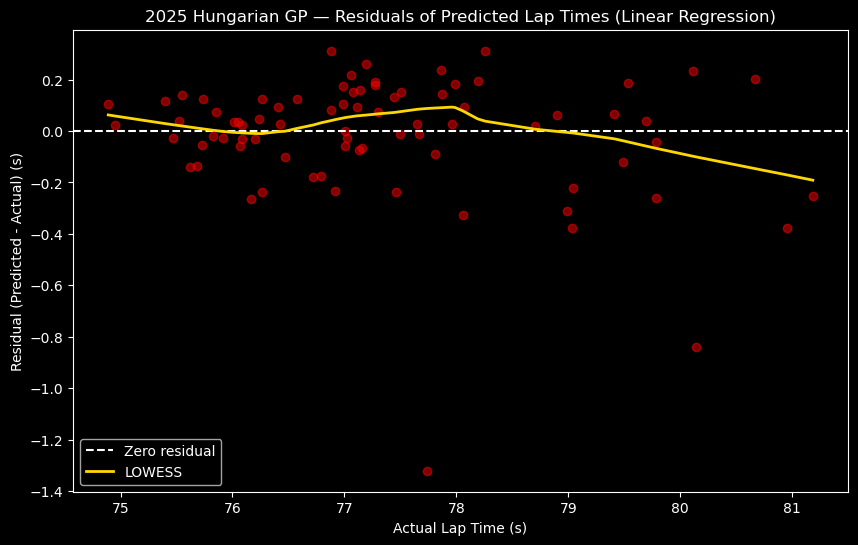

In [34]:
residuals = y_pred - y_test.values

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color="red", alpha=0.5)

# Plot horizontal line at zero residual
plt.axhline(
    0, color="white", linestyle="--", label="Zero residual"
)  

lowess_curve = lowess(residuals, y_test, frac=0.5) # X = y_test, Y = residuals, apply LOWESS smoothing
plt.plot(
    lowess_curve[:, 0], lowess_curve[:, 1], color="gold", linewidth=2, label="LOWESS"
)

plt.xlabel("Actual Lap Time (s)")
plt.ylabel("Residual (Predicted - Actual) (s)")
plt.title("2025 Hungarian GP — Residuals of Predicted Lap Times (Linear Regression)")
plt.legend(loc="lower left")
plt.show()

## 06 - Insights & Interpretation

## 07 - Conclusion & Next Steps